In [74]:
import polars as pl 
import polars.selectors as cs 
import seaborn as sns
import matplotlib.pyplot as plt
# import yfinance as yf
from yahoo_fin.stock_info import get_data
# import phoenix as px 
import umap
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.decomposition import KernelPCA
import utils
from dateutil.relativedelta import relativedelta 
import numpy as np
import seaborn.objects as so 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

ticker = "^DJI"#"^VIX" #"^FTSE" #"^RUT" #"^GSPC" #"^VIX" #"^990100-USD-STRD"
n_components = 500

to test against MSCI: recuced with umap (2,3,?), and PCA

test against pct_change and raw data

## Getting data

In [75]:
sentences = pl.read_parquet(r"C:\Users\faune\Desktop\thesis\daily_headlines.parquet")
msci_world = get_data(ticker=ticker, start_date="2008-01-01", end_date="2016-01-01")
msci_close = pl.DataFrame(msci_world[['close']].dropna().pct_change().reset_index())
to_join = msci_close.drop_nulls().with_columns(pl.col('index').cast(pl.Date)).rename({'index': 'date'})
sentences = sentences.with_columns(pl.col('date').cast(pl.Date))
frame = sentences.join(to_join, on='date').with_columns(pl.col('date').dt.quarter().alias('quarter'), pl.col('date').dt.year().alias('year'))
reducer = umap.UMAP(n_components=n_components)
reduced = reducer.fit_transform(frame.select('embeddings').to_series().to_list())
decomposer = KernelPCA(n_components=n_components)
decomposed =decomposer.fit_transform(frame.select('embeddings').to_series().to_list())


In [76]:
frame = frame.with_columns(pl.Series(name = 'reduced', values = reduced))
frame = frame.with_columns(pl.Series(name = 'decomposed', values = decomposed))

# sns.scatterplot(data = frame.with_columns(pl.col('reduced').list.to_struct()).unnest('reduced').rename({'field_0':'x', 'field_1':'y'}).select('x','y', 'label').to_pandas(), x= 'x', y = 'y', hue='label', palette = sns.cubehelix_palette(n_colors=3))

In [77]:
frame = frame.sort('date').set_sorted('date').with_columns(pl.col('close').rolling_std(by='date', window_size = '1w').alias('std'))

In [78]:
frame = frame.drop_nulls()

In [79]:
frame = frame.with_columns(pl.col('close').rolling_mean(window_size = '1mo', by='date').alias('mean'))

In [80]:
returns = frame.select('close').to_series()
q10 = returns.quantile(0.10)
q20 = returns.quantile(0.20)
q80 = returns.quantile(0.80)
q90 = returns.quantile(0.90)

In [81]:
frame = (
    frame
    .with_columns(
        pl.when((pl.col('close')>=(q90))).then(1)
        .when((pl.col('close')>=(q80)) & (pl.col('close')<(q90))).then(2)
        .when((pl.col('close')>=(q20)) & (pl.col('close')<(q80))).then(3)
        .when((pl.col('close')>=(q10)) & (pl.col('close')<(q20))).then(4)
        .when((pl.col('close')<(q10))).then(5)
        .alias('quantiles')
    )
)

<Axes: xlabel='field_0', ylabel='field_1'>

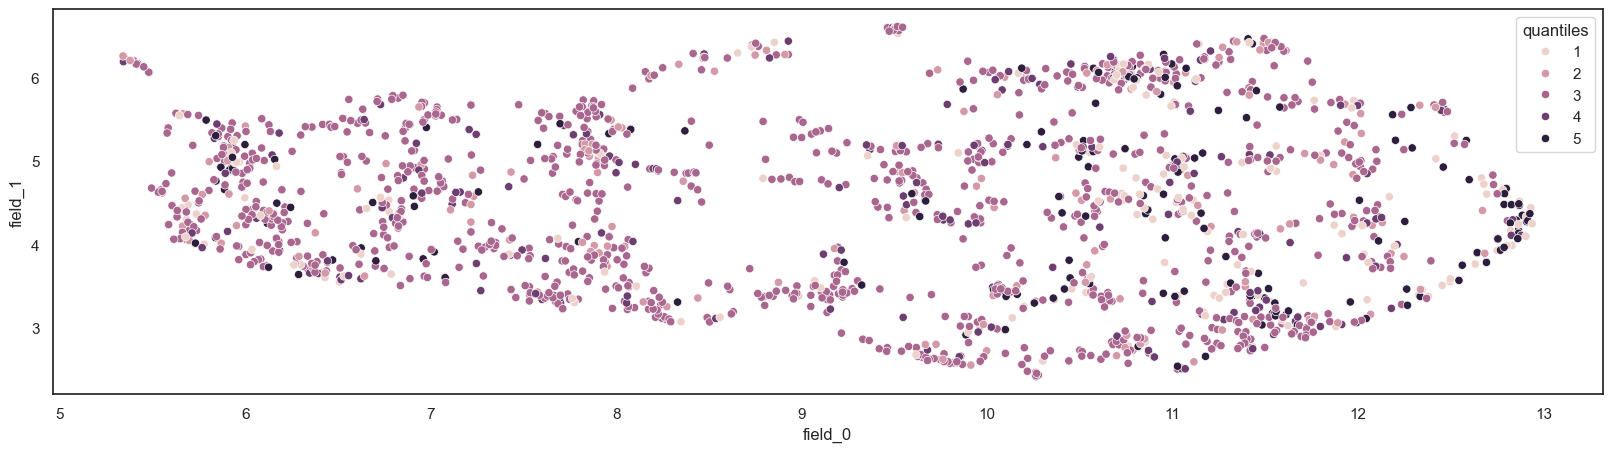

In [82]:
sns.scatterplot(data=frame.with_columns(pl.col('reduced').list.to_struct()).unnest('reduced').to_pandas(), x = 'field_0', y = 'field_1', hue = 'quantiles')

## Getting lineplots

In [83]:
def get_linear_regression(x_col: str, y_col: str, df: pl.DataFrame, model_type: str, intercept: bool = True, start_year: int =2008):
    if model_type == 'ols':
        model = LinearRegression(fit_intercept=intercept)
    elif model_type == 'ridge':
        model = Ridge(fit_intercept=intercept)
    elif model_type == 'lasso':
        model = Lasso(fit_intercept=intercept)
    elif model_type == 'elastic net':
        model = ElasticNet(fit_intercept=intercept)

    df = df.filter(pl.col('date').dt.year().ge(start_year))

    X = df.select(pl.col(x_col)).to_series().to_list()
    y = df.select(pl.col(y_col)).to_series().to_list()
    
    ind = -int(len(X)/3)

    reg = model.fit(X[:ind], y[:ind])

    out_of_sample = np.dot(a=reg.coef_, b=np.transpose(X[ind:]))
    in_sample = reg.predict(X[:ind])
    predicted = np.append(in_sample, out_of_sample)

    with_predicted = df.with_columns(pl.Series(name = "predictions", values = predicted))
    with_predicted = with_predicted.select('date', y_col, 'predictions') 

    sns.set_theme(context='notebook', rc={'figure.figsize':(20,5)}, palette=sns.cubehelix_palette(2), style='white')
    sns.lineplot(data = with_predicted.to_pandas().set_index('date'))
    plt.axvline(with_predicted.select('date')[ind].to_series().to_list()[0], 0,1, color = 'blue')
    plt.text(x=with_predicted.select('date')[ind].to_series().to_list()[0] + relativedelta(years=1), y = max(out_of_sample) + 0.05, s = "Out of Sample")

    # print("Coefficients: \n", reg.coef_)
    plt.text(x=with_predicted.select('date')[0].to_series().to_list()[0] - relativedelta(years=3, month=10),y=0,s=f"Mean squared error (in sample): {mean_squared_error(y[:ind], in_sample):.2f}")
    plt.text(x=with_predicted.select('date')[0].to_series().to_list()[0] - relativedelta(years=3, month=10),y=-0.01,s=f"Coefficient of determination (in sample): {r2_score(y[:ind], in_sample):.2f}")
    plt.text(x=with_predicted.select('date')[0].to_series().to_list()[0] - relativedelta(years=3, month=10),y=-0.02,s=f"Mean squared error (out of sample): {mean_squared_error(y[ind:], out_of_sample):.2f}")
    plt.text(x=with_predicted.select('date')[0].to_series().to_list()[0] - relativedelta(years=3, month=10),y=-0.03,s= f"Coefficient of determination (out of sample): {r2_score(y[ind:], out_of_sample):.2f}")

    print(f"Mean squared error (in sample): {mean_squared_error(y[:ind], in_sample):.2f}")
    print(f"Coefficient of determination (in sample): {r2_score(y[:ind], in_sample):.2f}")
    print(f"Mean squared error (out of sample): {mean_squared_error(y[ind:], out_of_sample):.2f}")
    print(f"Coefficient of determination (out of sample): {r2_score(y[ind:], out_of_sample):.2f}")
    print(f"Average of the prediction : {np.mean(out_of_sample)}")
    print(f"Average of the true values : {np.mean(y[ind:])}")
    print(f"Std of the prediction : {np.std(out_of_sample)}")
    print(f"Std of the true values : {np.std(y[ind:])}")

    return

Mean squared error (in sample): 0.00
Coefficient of determination (in sample): 0.50
Mean squared error (out of sample): 0.00
Coefficient of determination (out of sample): -3.73
Average of the prediction : 0.000541608138692057
Average of the true values : -0.0001054548262375593
Std of the prediction : 0.015681429730166615
Std of the true values : 0.00792764879251458


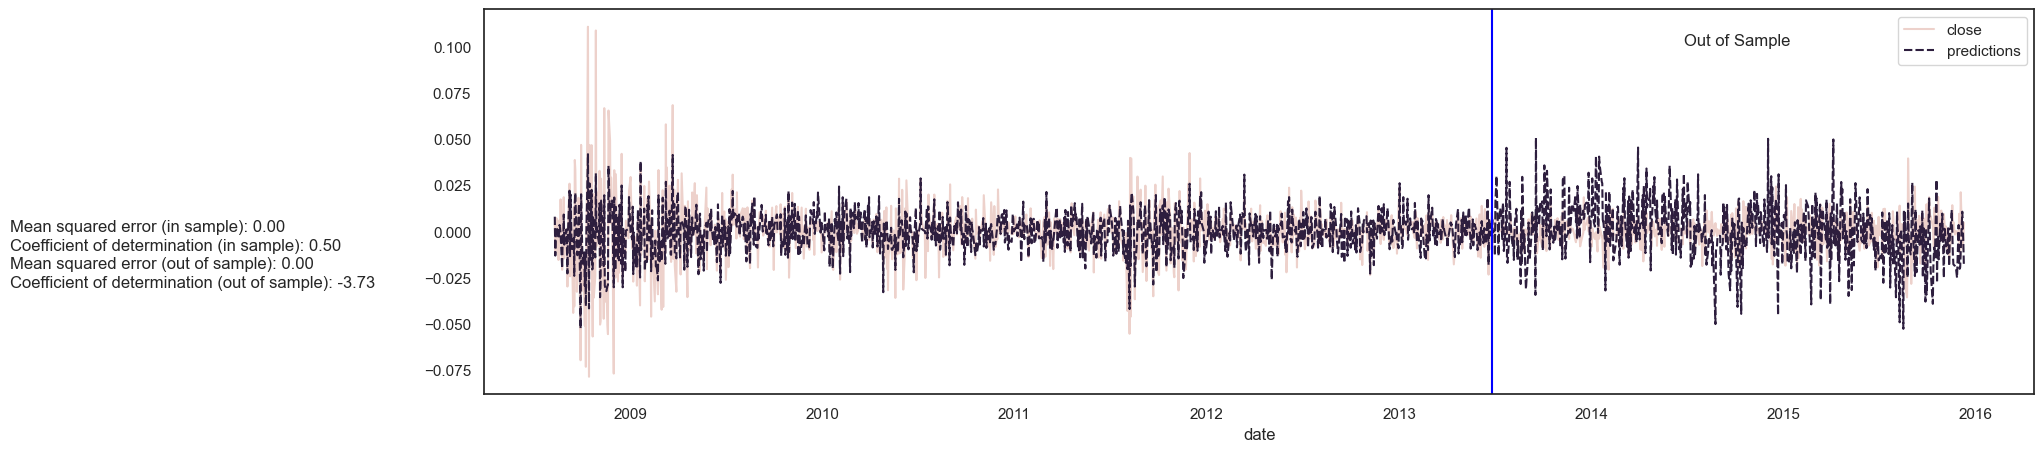

In [84]:
get_linear_regression(x_col='decomposed', y_col='close', df=frame, model_type = 'ols', intercept = False, start_year = 2008)

## Getting Logistic Regression

In [85]:
def get_logistic_regression(df: pl.DataFrame, penalty: str, x_col: str, y_col: str = 'quantiles'):
    model = LogisticRegression(penalty=penalty, multi_class='multinomial')
    X = df.select(pl.col(x_col)).to_series().to_list()
    y = df.select(pl.col(y_col)).to_series().to_list()

    ind = -int(len(X)/3)

    X_test = X[ind:]
    X_train = X[:ind]

    y_test = y[ind:]
    y_train = y[:ind]

    reg = model.fit(X_train, y_train)

    out_of_sample = reg.predict(X_test)
    in_sample = reg.predict(X_train)

    print('Accuracy:', accuracy_score(y_train, in_sample))
    print('Precision:', precision_score(y_train, in_sample, average='weighted'))
    print('Recall:', recall_score(y_train, in_sample, average='weighted'))
    print('F1 score:', f1_score(y_train, in_sample, average='weighted'))
    print('Confusion matrix:\n', confusion_matrix(y_train, in_sample))

    print('Accuracy (Out of Sample):', accuracy_score(y_test, out_of_sample))
    print('Precision (Out of Sample):', precision_score(y_test, out_of_sample, average='weighted'))
    print('Recall (Out of Sample):', recall_score(y_test, out_of_sample, average='weighted'))
    print('F1 score (Out of Sample):', f1_score(y_test, out_of_sample, average='weighted'))
    print('Confusion matrix (Out of Sample):\n', confusion_matrix(y_test, out_of_sample))

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    cm = confusion_matrix(y_train, in_sample)
    axs[0].matshow(cm, cmap=plt.cm.Blues)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axs[0].text(j, i, cm[i, j], ha='center', va='center')
    axs[0].set_xlabel('Predicted Class')
    axs[0].set_ylabel('True Class')
    axs[0].set_title('In Sample')

    cm = confusion_matrix(y_test, out_of_sample)
    axs[1].matshow(cm, cmap=plt.cm.Blues)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axs[1].text(j, i, cm[i, j], ha='center', va='center')
    axs[1].set_xlabel('Predicted Class')
    axs[1].set_ylabel('True Class')
    axs[1].set_title('Out of Sample')

    plt.tight_layout()
    plt.show()
    
    return

Accuracy: 0.5593368237347295
Precision: 0.4306370670839241
Recall: 0.5593368237347295
F1 score: 0.4056805870784
Confusion matrix:
 [[  0   0 137   0   0]
 [  0   0 117   0   0]
 [  0   0 636   0   0]
 [  0   0 117   0   0]
 [  0   0 134   0   5]]
Accuracy (Out of Sample): 0.6905594405594405
Precision (Out of Sample): 0.47687234094576747
Recall (Out of Sample): 0.6905594405594405
F1 score (Out of Sample): 0.5641592120392533
Confusion matrix (Out of Sample):
 [[  0   0  36   0   0]
 [  0   0  54   0   0]
 [  0   0 395   0   0]
 [  0   0  54   0   0]
 [  0   0  33   0   0]]


c:\Users\faune\miniconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\faune\miniconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


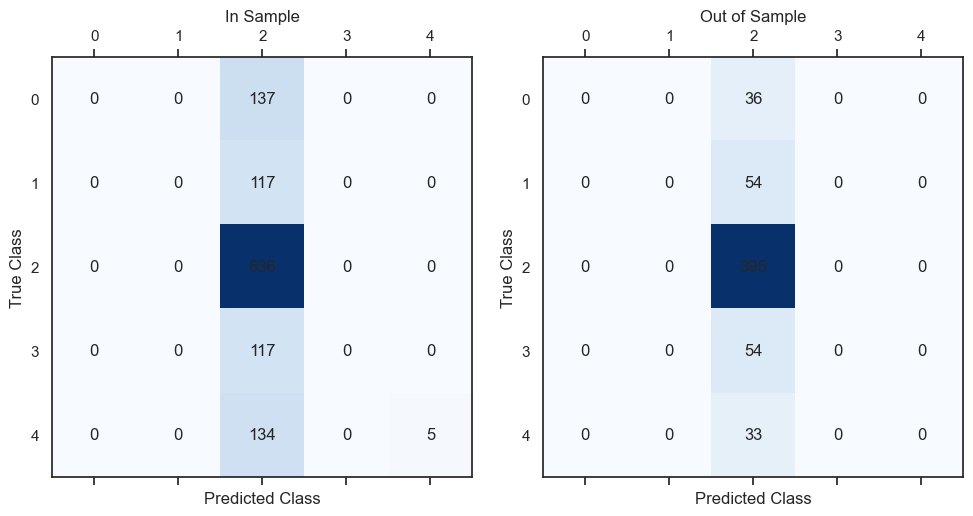

In [89]:
get_logistic_regression(df=frame, penalty = 'l2', x_col = 'embeddings')